In [10]:
# !pip install midiutil


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from midiutil import MIDIFile


In [12]:
url = 'https://raw.githubusercontent.com/Colmeman/VolafoneSER/06e583b2df3277a175c15157c67dceb5eabed6d3/Data/Call_log_anger.csv'
anger_data = pd.read_csv(url)


,Agent_ID,Call_Date,Talk_Time,After_Call_Work_Time,Queue_Time,Call_resolution_ID,Call_Type_ID,Plan_ID,Emotion
0,32240,2017-01-01 00:00:00,836,184,16,Resolution1,Type30,Plan1,anger
1,32410,2017-01-01 00:00:00,2098,558,10,Resolution2,Type40,Plan3,anger
2,26210,2017-01-01 00:00:00,1027,290,2,Resolution2,Type50,Plan5,anger
3,14270,2017-01-01 00:00:00,2642,1027,12,Resolution3,Type20,Plan4,anger
4,26200,2017-01-01 00:00:00,1154,427,1,Resolution3,Type50,Plan5,anger
...,...,...,...,...,...,...,...,...,...
404950,14300,2019-06-30 00:00:00,874,340,27,Resolution1,Type50,Plan3,anger
404951,26310,2019-06-30 00:00:00,1242,459,19,Resolution1,Type20,Plan4,anger
404952,32260,2019-06-30 00:00:00,159,53,14,Resolution1,Type30,Plan4,anger
404953,32340,2019-06-30 00:00:00,423,164,10,Resolution2,Type20,Plan3,anger


## FCR (First Call Resolution) Function

Have to change the output_path to save the midi file 

In [25]:

def sonify_agent_data_FCR(anger_data):
    anger_data['Call_Date'] = pd.to_datetime(anger_data['Call_Date'], format='%Y-%m-%d %H:%M:%S')  # Adjust the format as needed

    while True:
        # Request Agent ID from the user
        agent_id = int(input("Enter Agent ID: "))
        
        # Check if the Agent ID exists in the data
        if agent_id not in anger_data['Agent_ID'].unique():
            print(f"Agent ID {agent_id} does not exist in the data. Please enter a valid Agent ID.")
            continue
        
        # Request Year from the user
        year = input("Enter Year(2017-2018): ")
        
        # Check if the Year is valid
        if year not in anger_data['Call_Date'].dt.year.astype(str).unique():
            print(f"Year {year} is not valid. Please enter a valid Year.")
            continue
        
        # Request Month from the user
        month = input("Enter Month (01-12): ")
        
        # Check if the Month is valid
        if month not in [str(i).zfill(2) for i in range(1, 13)]:
            print(f"Month {month} is not valid. Please enter a valid Month.")
            continue
        
        # Request Threshold from the user
        threshold = int(input("Enter Threshold Value (from 75(recomended) to 95): "))
        
        # Check if the Threshold is valid
        if not (75 <= threshold <= 95):
            print(f"Threshold {threshold} is not valid. Please enter a valid Threshold between 900 and 1800.")
            continue

        
        # Request Sonification Type from the user
        sonification_type = input("Enter Sonification Type (s for simple or v for varied pitch): ").strip().lower()
        
        if sonification_type not in ['s', 'v']:
            print("Sonification Type must be 's' for simple or 'v' for varied pitch. Please enter a valid Sonification Type.")
            continue
        
        data_agent = anger_data[anger_data['Agent_ID'] == agent_id].copy()

        # Extract the year and month from 'Call_Date'
        data_agent['Year'] = data_agent['Call_Date'].dt.year
        data_agent['Month'] = data_agent['Call_Date'].dt.month

        filtered_data = data_agent[(data_agent['Year'] == int(year)) & (data_agent['Month'] == int(month))]

        # Calculate the total number of calls for each day in the specific month
        total_calls_by_day = filtered_data.groupby(filtered_data['Call_Date'].dt.day)['Agent_ID'].count().reset_index()
        total_calls_by_day.columns = ['Day', 'Total Calls']

        # Calculate the number of calls with 'Resolution1' for each day in the specific month
        resolution1_calls_by_day = filtered_data[filtered_data['Call_resolution_ID'] == 'Resolution1'].groupby(
            filtered_data['Call_Date'].dt.day)['Agent_ID'].count().reset_index()
        resolution1_calls_by_day.columns = ['Day', 'Resolution1 Calls']

        # Merge the two DataFrames on 'Day'
        resolution_percentage_daily_in_a_month_data = pd.merge(total_calls_by_day, resolution1_calls_by_day, on='Day', how='left')

        # Fill NaN values with 0 (in case there are days with no 'Resolution1' calls)
        resolution_percentage_daily_in_a_month_data['Resolution1 Calls'] = resolution_percentage_daily_in_a_month_data['Resolution1 Calls'].fillna(0)

        # Calculate the percentage of 'Resolution1' calls for each day in the specific month
        resolution_percentage_daily_in_a_month_data['Resolution1 Percentage'] = (resolution_percentage_daily_in_a_month_data['Resolution1 Calls'] / resolution_percentage_daily_in_a_month_data['Total Calls']) * 100

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the data
        ax.plot(resolution_percentage_daily_in_a_month_data['Day'], resolution_percentage_daily_in_a_month_data['Resolution1 Percentage'], marker='o', linestyle='-')

        # Add a horizontal line for the threshold
        
        ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')

        # Set labels and title
        ax.set_xlabel('Day')
        ax.set_ylabel('Percentage of Resolution1 Calls')
        ax.set_title(f'Percentage of Resolution1 Calls per Day in {year}-{month}')

        # Show the legend
        ax.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Create a MIDI file
        midi_file = MIDIFile(1)  # One track

        # Define MIDI parameters
        track = 0
        channel = 0
        time = 0  # Initial time
        velocity = 100  # Adjust as needed
        duration = 1  # Adjust as needed
        min_pitch_below_threshold = 72  # Adjust the minimum pitch value
        max_pitch_below_threshold = 96  # Adjust the maximum pitch value

        # Pitch range for values above or equal to the threshold
        min_pitch_above_threshold = 48  # Adjust the minimum pitch value
        max_pitch_above_threshold = 60  # Adjust the maximum pitch value
        
        # Add notes to the MIDI file based on your data and sonification type
        for index, row in resolution_percentage_daily_in_a_month_data.iterrows():
            resolution_percentage = row['Resolution1 Percentage']

            # Determine pitch and volume based on the sonification type
            if sonification_type == 's':
                if resolution_percentage >= threshold:
                    # Lower pitch and lower volume for values above or equal to the threshold
                    pitch = 60  # Adjust the pitch value as needed
                    volume = 64  # Adjust the volume value as needed
                else:
                    # High pitch and higher volume for values below the threshold
                    pitch = 72  # Adjust the pitch value as needed
                    volume = 96  # Adjust the volume value as needed
            elif sonification_type == 'v':
                
                # Define pitch variation based on the sonification type and threshold
                # Calculate pitch based on the threshold and pitch range
                if resolution_percentage >= threshold:
                    # Calculate pitch within the smaller range (inverted)
                    pitch = max_pitch_above_threshold - (max_pitch_above_threshold - min_pitch_above_threshold) * (resolution_percentage - threshold) / (100 - threshold)
                    volume = 64  # Adjust the volume value as needed
                else:
                    # Calculate pitch within the larger range (inverted)
                    pitch = max_pitch_below_threshold - (max_pitch_below_threshold - min_pitch_below_threshold) * resolution_percentage / threshold
                    volume = 96  # Adjust the volume value as needed
            
            # Add the note to the MIDI file
            midi_file.addNote(
                track,
                channel=channel,
                pitch=int(pitch),
                time=time,
                duration=duration,
                volume=100,
            )
            
            # Increment the time for the next note
            time += 1  # You can adjust the time increment as needed

        # Save the MIDI file to a specific path and filename
        output_path = 'c:/Users/gusta/Documents/Data Science Bootcamp/Data Science/Final Project/Data/sonified_FCR_function.mid'

        with open(output_path, 'wb') as midi_output:
            midi_file.writeFile(midi_output)

        return f"Sonified data for Agent {agent_id} in {year}-{month} saved as {output_path}"

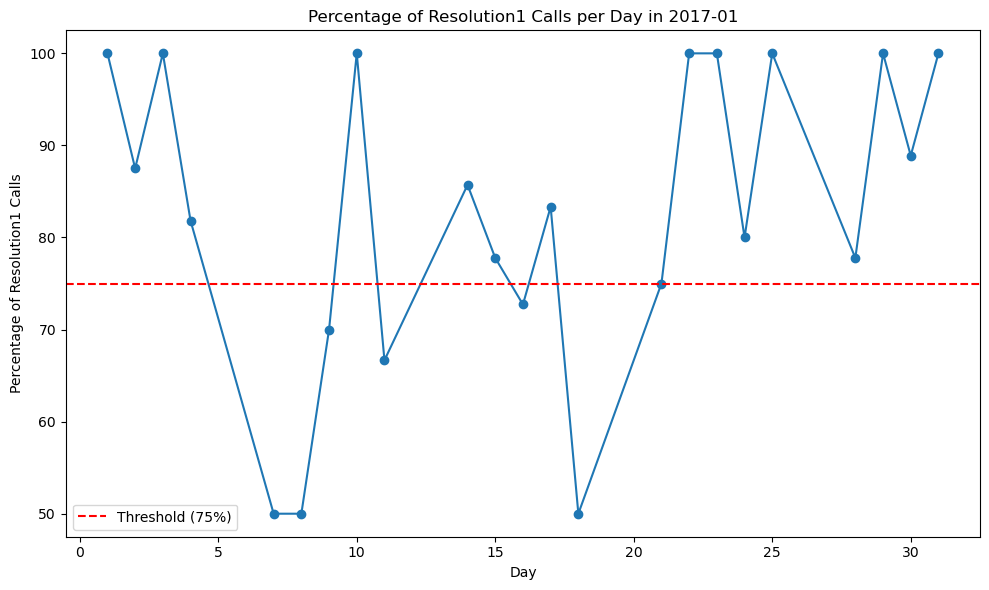

'Sonified data for Agent 32400 in 2017-01 saved as c:/Users/gusta/Documents/Data Science Bootcamp/Data Science/Final Project/Data/sonified_FCR_function.mid'

In [26]:
sonify_agent_data_FCR(anger_data)